In [112]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [113]:
df = pd.read_csv("/Users/vittorio/Projects/uni/CV/assingment_1_proj_geom/data/image_annotations.csv")

In [114]:
def extract_line(df, label):
    points = df[df['label'].str.contains(label)]
    print(points)
    if len(points) != 2:
        raise ValueError(f"Expected 2 points for label '{label}', but found {len(points)}")
    p1 = np.array([points.iloc[0]['x'], points.iloc[0]['y'], 1])
    p2 = np.array([points.iloc[1]['x'], points.iloc[1]['y'], 1])
    return np.cross(p1, p2)

In [115]:
df.head()

x        y  label            timestamp
0  3134.46  2356.20  d_fla  2025-03-21 16:27:24
1  3177.30  1349.46  u_fla  2025-03-21 16:27:30
2  1385.16  3898.44  d_bea  2025-03-21 16:27:40
3  1392.30  1299.48  u_bea  2025-03-21 16:27:47
4     7.14  3113.04   l_h1  2025-03-21 16:28:00

In [116]:
lines = {
    "flavio": extract_line(df, "fla"),
    "bea": extract_line(df, "bea"),
    "horizontal1": [
        extract_line(df, "h1"),
        extract_line(df, "h2"),
        extract_line(df, "h3"),
        extract_line(df, "h4"),
    ],
    "horizontal2": [
        extract_line(df, "l1"),
        extract_line(df, "l2"),
        extract_line(df, "l3"),
        extract_line(df, "l4"),
    ],
    "vertical": [
        extract_line(df, "v1"),
        extract_line(df, "v2"),
        extract_line(df, "v3"),
        extract_line(df, "v4"),
    ]
}

         x        y  label            timestamp
0  3134.46  2356.20  d_fla  2025-03-21 16:27:24
1  3177.30  1349.46  u_fla  2025-03-21 16:27:30
         x        y  label            timestamp
2  1385.16  3898.44  d_bea  2025-03-21 16:27:40
3  1392.30  1299.48  u_bea  2025-03-21 16:27:47
         x        y label            timestamp
4     7.14  3113.04  l_h1  2025-03-21 16:28:00
5  3484.32  1842.12  r_h1  2025-03-21 16:28:15
         x       y label            timestamp
6  5176.50  2891.7  l_h2  2025-03-21 16:28:33
7  4448.22  1713.6  r_h2  2025-03-21 16:28:43
        x        y label            timestamp
8    7.14  2320.50  l_h3  2025-03-21 16:28:52
9  892.50  2149.14  r_h3  2025-03-21 16:29:04
          x        y label            timestamp
10  2434.74  1185.24  l_h4  2025-03-21 16:30:05
11  3734.22  1435.14  r_h4  2025-03-21 16:30:15
          x        y label            timestamp
22    14.28  1170.96  l_l1  2025-03-21 16:33:46
23  2327.64  1228.08  r_l1  2025-03-21 16:33:52
       

In [117]:
def estimate_vanishing_point(lines):
    A = np.vstack(lines)
    _, _, V = np.linalg.svd(A)
    vp = V[-1, :]
    vp = vp / vp[2]
    return vp

h_1 = estimate_vanishing_point(lines['horizontal1'])
h_2 = estimate_vanishing_point(lines['horizontal2'])
v_vert = estimate_vanishing_point(lines['vertical'])

In [118]:
v

array([2.14040462e+03, 2.61619825e+04, 1.00000000e+00])

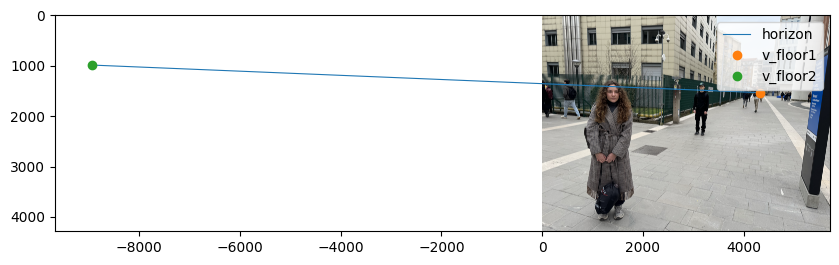

In [119]:
img = cv2.imread("/Users/vittorio/Projects/uni/CV/assingment_1_proj_geom/data/IMG_0299.png")[:, :, ::-1]

horizon = np.cross(h_1, h_2)
horizon = horizon/horizon[-1]

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.plot([h_1[0], h_2[0]], [h_1[1], h_2[1]],
         label="horizon", linewidth=0.8)

plt.plot(h_1[0], h_1[1], "o", label="v_floor1")
plt.plot(h_2[0], h_2[1], "o", label="v_floor2")
plt.legend()

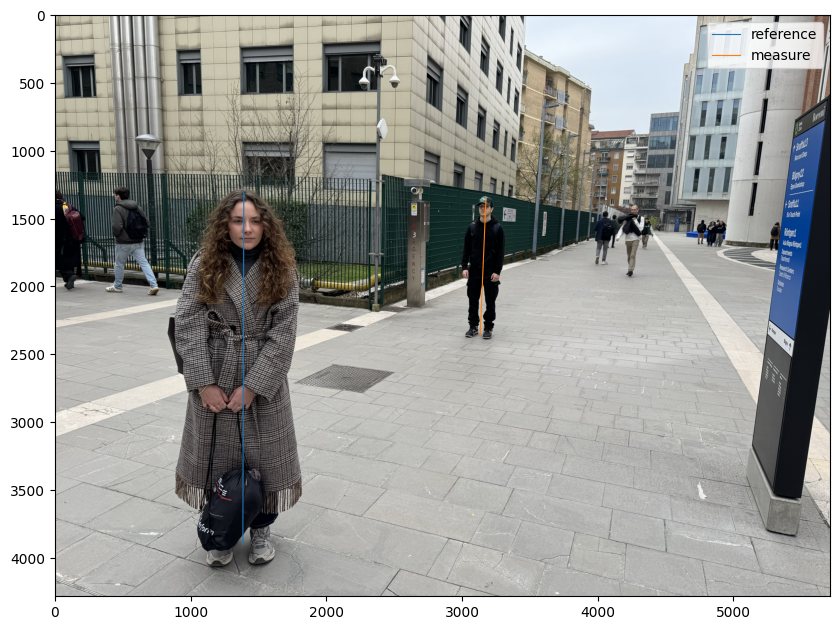

In [120]:
ref_bottom = df.loc[df['label'] == 'u_bea', ['x', 'y']].values[0]
ref_top = df.loc[df['label'] == 'd_bea', ['x', 'y']].values[0]
measure_top = df.loc[df['label'] == 'u_fla', ['x', 'y']].values[0]
measure_bottom = df.loc[df['label'] == 'd_fla', ['x', 'y']].values[0]

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.plot([ref_bottom[0], ref_top[0]], [ref_bottom[1], ref_top[1]], label="reference", linewidth=0.8)
plt.plot([measure_bottom[0], measure_top[0]], [measure_bottom[1], measure_top[1]], label="measure", linewidth=0.8)
plt.legend()

In [121]:
ref_bottom = df.loc[df['label'] == 'u_bea', ['x', 'y']].values[0]
ref_top = df.loc[df['label'] == 'd_bea', ['x', 'y']].values[0]
measure_top = df.loc[df['label'] == 'u_fla', ['x', 'y']].values[0]
measure_bottom = df.loc[df['label'] == 'd_fla', ['x', 'y']].values[0]

ref_bottom = np.array([ref_bottom[0], ref_bottom[1], 1])
ref_top = np.array([ref_top[0], ref_top[1], 1])
measure_top = np.array([measure_top[0], measure_top[1], 1])
measure_bottom = np.array([measure_bottom[0], measure_bottom[1], 1])

u = np.cross(np.cross(measure_bottom, ref_bottom), horizon)
u = u/u[-1]

l_measure = np.cross(measure_bottom, v_vert)
ref_top_tilde = np.cross(np.cross(ref_top, u),l_measure)
ref_top_tilde = ref_top_tilde/ref_top_tilde[-1]

dist_ref_top_tilde = np.linalg.norm(ref_top_tilde - ref_bottom)
dist_measure_top = np.linalg.norm(measure_top - measure_bottom)
dist_vert = np.linalg.norm(v_vert - ref_bottom)

# Compute 1d projective transformation mapping the vanishing point to infinity
# (0,1) -> (0,1)
# (v_vert,0) -> (1,0)

H = np.eye(2)
H[-1] = [1,dist_vert]

# Compute the distance ratio

dist_ref_measure_ratio = dist_ref_top_tilde * (dist_vert - dist_measure_top)/(dist_measure_top*(dist_vert-dist_ref_top_tilde))

# Measured dist = ref_dist / dist_ref_measure_ratio
ref_dist = 163
measured_dist = ref_dist / dist_ref_measure_ratio
print(measured_dist)

-2.521283939249866


(np.float64(-0.5), np.float64(5711.5), np.float64(4283.5), np.float64(-0.5))

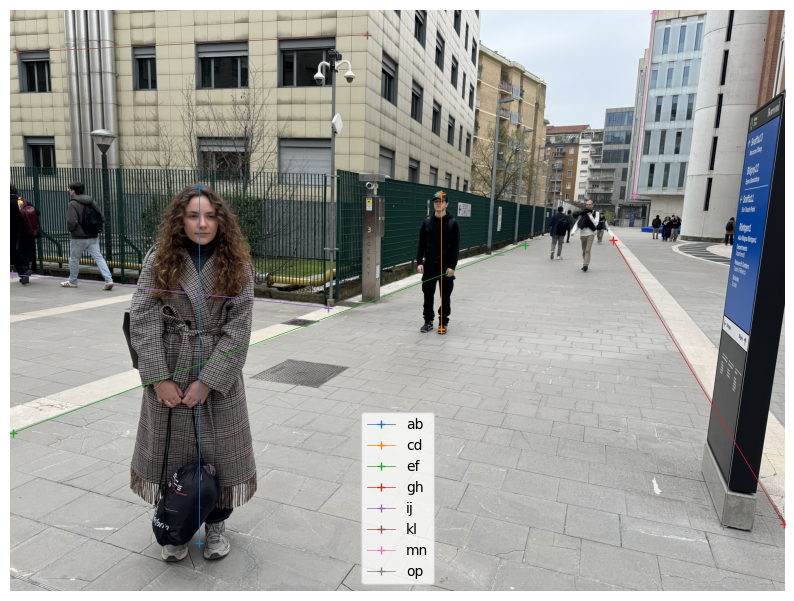

In [122]:
img = cv2.imread("/Users/vittorio/Projects/uni/CV/assingment_1_proj_geom/data/IMG_0299.png")[:, :, ::-1]


# height
a = np.array([1395, 1303, 1])
b = np.array([1395, 3932, 1])
c = np.array([3173, 1354, 1])
d = np.array([3173, 2350, 1])

# horizontal
e = np.array([18, 3120, 1])
f = np.array([3795, 1730, 1])
g = np.array([5705, 3790, 1])
h = np.array([4442, 1694, 1])

# horizontal 2
i = np.array([2340, 2196, 1])
j = np.array([15, 1950, 1])
k = np.array([2634, 184, 1])
l = np.array([48, 314, 1])


# vertical
m = np.array([4601, 1363, 1])
n = np.array([4746, 22, 1])
o = np.array([5251, 3805, 1])
p = np.array([5711, 611, 1])


plt.figure(figsize=(10,10))
plt.imshow(img)
plt.plot([a[0], b[0]], [a[1], b[1]], marker="+", label="ab", linewidth=0.5)
plt.plot([c[0], d[0]], [c[1], d[1]], marker="+", label="cd", linewidth=0.5)
plt.plot([e[0], f[0]], [e[1], f[1]], marker="+", label="ef", linewidth=0.5)
plt.plot([g[0], h[0]], [g[1], h[1]], marker="+", label="gh", linewidth=0.5)
plt.plot([i[0], j[0]], [i[1], j[1]], marker="+", label="ij", linewidth=0.5)
plt.plot([k[0], l[0]], [k[1], l[1]], marker="+", label="kl", linewidth=0.5)
plt.plot([m[0], n[0]], [m[1], n[1]], marker="+", label="mn", linewidth=0.5)
plt.plot([o[0], p[0]], [o[1], p[1]], marker="+", label="op", linewidth=0.5)


plt.legend()



plt.imshow(img)
plt.axis('off')

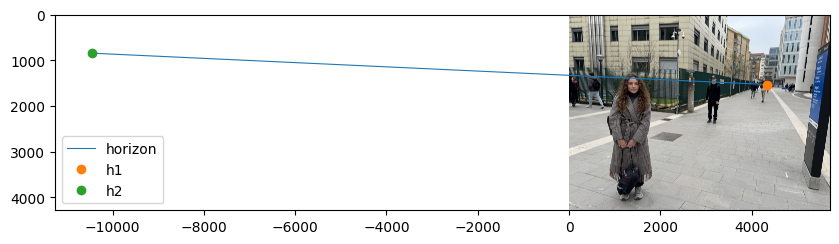

In [123]:
lef = np.cross(e, f)
lgh = np.cross(g, h)
lij = np.cross(i, j)
lkl = np.cross(k, l)
lmn = np.cross(m, n)
lop = np.cross(o, p)


h1 = np.cross(lef, lgh)
h2 = np.cross(lij, lkl)
v_vert = np.cross(lmn, lop)

h1 = h1/h1[-1]
h2 = h2/h2[-1]
v_vert = v_vert/v_vert[-1]


# Compute horizon line for floor plane
horizon = np.cross(h1, h2)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.plot([h1[0], h2[0]], [h1[1], h2[1]],
         label="horizon", linewidth=0.8)

plt.plot(h1[0], h1[1], "o", label="h1")
plt.plot(h2[0], h2[1], "o", label="h2")
plt.legend()

In [124]:
# Important: normalize the horizon line coefficients to regularize the homography
horizon = horizon/np.linalg.norm(horizon)

H = np.hstack([np.eye(2), np.zeros((2, 1))])
H = np.vstack([H, horizon])

H = H/H[-1, -1]

# We can check that the horizon is now mapped to the canonical line at the infinity H^(-T)@horizon
print(f"{np.linalg.inv(H).T@horizon.reshape((-1,1))}")

[[-1.01719045e-21]
 [ 0.00000000e+00]
 [ 9.99999716e-01]]


In [130]:
measure_bottom = c
measure_top = d

ref_bottom = a
ref_top = b

u = np.cross(np.cross(measure_bottom, ref_bottom), horizon)
u = u/u[-1]

l_measure = np.cross(measure_bottom, v_vert)
ref_top_tilde = np.cross(np.cross(ref_top, u),l_measure)
ref_top_tilde = ref_top_tilde/ref_top_tilde[-1]

dist_ref_top_tilde = np.linalg.norm(ref_top_tilde - ref_bottom)
dist_measure_top = np.linalg.norm(measure_top - measure_bottom)
dist_vert = np.linalg.norm(v_vert - ref_bottom)

# Compute 1d projective transformation mapping the vanishing point to infinity
# (0,1) -> (0,1)
# (v_vert,0) -> (1,0)

H = np.eye(2)
H[-1] = [1,dist_vert]

# Compute the distance ratio

dist_ref_measure_ratio = dist_ref_top_tilde * (dist_vert - dist_measure_top)/(dist_measure_top*(dist_vert-dist_ref_top_tilde))

# Measured dist = ref_dist / dist_ref_measure_ratio
ref_dist = 163
measured_dist = ref_dist / dist_ref_measure_ratio
print(measured_dist)

37.7823223957885


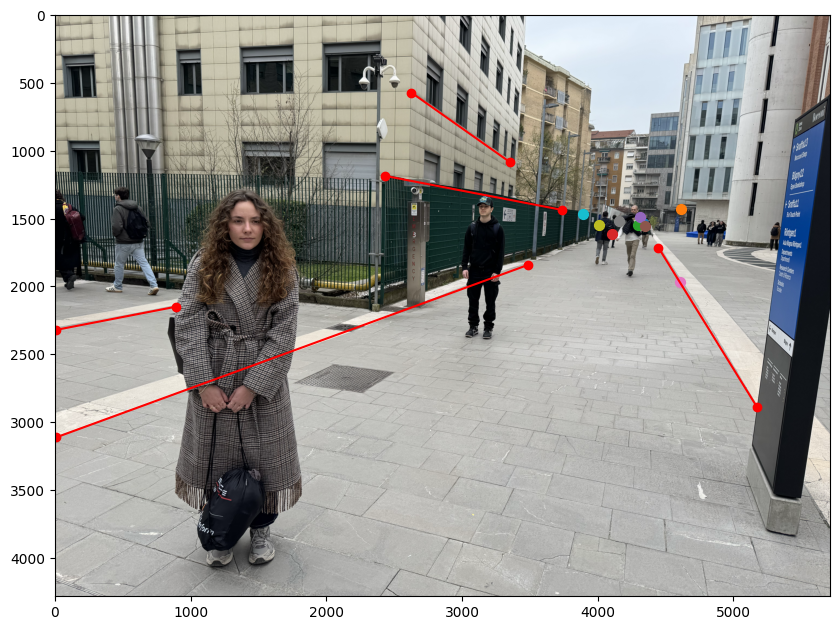

In [77]:
points = [np.array([p['x'], p['y'], 1]) for _, p in df[df.label.str.contains("_h")].iterrows()]


plt.figure(figsize=(10,10))
plt.imshow(img)

lines = []

for i in range(0, len(points), 2):
    p1 = points[i]
    p2 = points[i + 1]

    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'ro-')
    line = np.cross(p1, p2)
    lines.append(line / line[-1])

#create the vanishing points by intersecting all the lines with each other
vanishing_points = []
for i in range(len(lines)):
    for j in range(i + 1, len(lines)):
        line1 = lines[i]
        line2 = lines[j]
        vanishing_point = np.cross(line1, line2)
        vanishing_points.append(vanishing_point / vanishing_point[-1])

for vp in vanishing_points:
    plt.scatter(vp[0], vp[1], s=50)

plt.show()

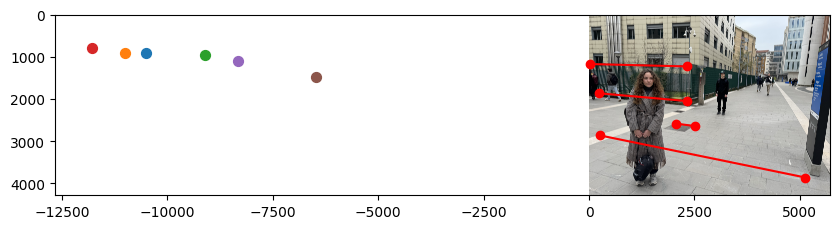

In [131]:
points = [np.array([p['x'], p['y'], 1]) for _, p in df[df.label.str.contains("_l")].iterrows()]


plt.figure(figsize=(10,10))
plt.imshow(img)

lines = []

for i in range(0, len(points), 2):
    p1 = points[i]
    p2 = points[i + 1]

    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'ro-')
    line = np.cross(p1, p2)
    lines.append(line / line[-1])

#create the vanishing points by intersecting all the lines with each other
vanishing_points = []
for i in range(len(lines)):
    for j in range(i + 1, len(lines)):
        line1 = lines[i]
        line2 = lines[j]
        vanishing_point = np.cross(line1, line2)
        vanishing_points.append(vanishing_point / vanishing_point[-1])

for vp in vanishing_points:
    plt.scatter(vp[0], vp[1], s=50)

plt.show()

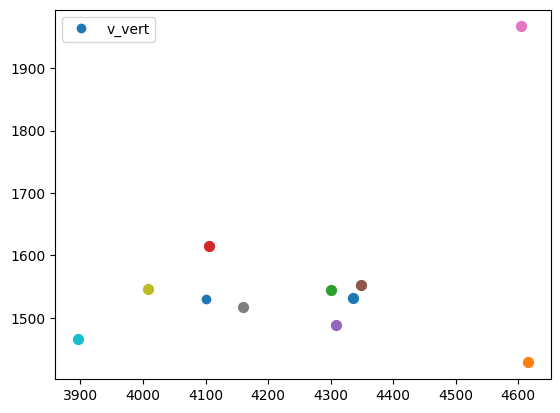

In [ ]:
vertical_lines = np.array(lines)
_,_,vt = np.linalg.svd(vertical_lines)
v_vert = vt[-1,:]
v_vert = v_vert/v_vert[-1]

for vp in vanishing_points:
    plt.scatter(vp[0], vp[1], s=50)
plt.plot(v_vert[0], v_vert[1], "o", label="v_vert")
plt.legend()

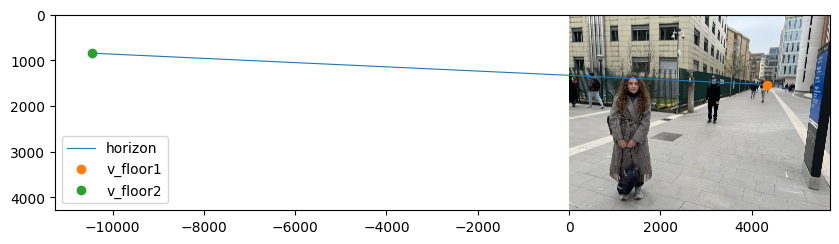

In [19]:
horizon = np.cross(v1, v2)
horizon = horizon/horizon[-1]

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.plot([v1[0], v2[0]], [v1[1], v2[1]],
         label="horizon", linewidth=0.8)

plt.plot(v1[0], v1[1], "o", label="v_floor1")
plt.plot(v2[0], v2[1], "o", label="v_floor2")
plt.legend()

In [20]:
# Important: normalize the horizon line coefficients to regularize the homography
horizon = horizon/np.linalg.norm(horizon)

H = np.hstack([np.eye(2), np.zeros((2, 1))])
H = np.vstack([H, horizon])

H = H/H[-1, -1]

# We can check that the horizon is now mapped to the canonical line at the infinity H^(-T)@horizon
print(f"{np.linalg.inv(H).T@horizon.reshape((-1,1))}")

[[-3.18466576e-23]
 [ 0.00000000e+00]
 [ 9.99999716e-01]]


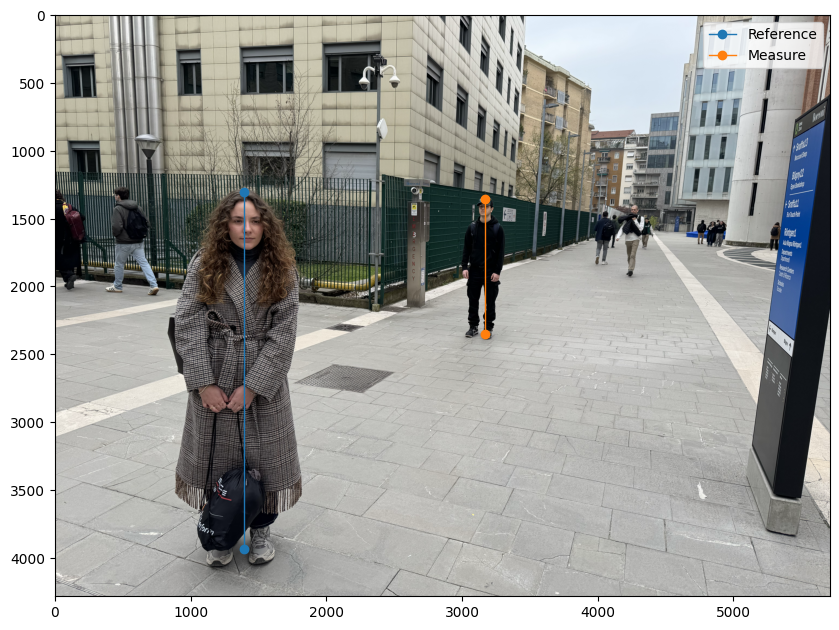

In [21]:
ref_top =  a.copy()
ref_bottom =  b.copy()

measure_top = c.copy()
measure_bottom = d.copy()


plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.plot([ref_top[0], ref_bottom[0]], [ref_top[1], ref_bottom[1]],
         marker="o", label="Reference", linewidth=1)
plt.plot([measure_top[0], measure_bottom[0]], [measure_top[1], measure_bottom[1]],
         marker="o", label="Measure", linewidth=1)
plt.legend()

In [26]:
u = np.cross(np.cross(measure_bottom, ref_bottom), horizon)
u = u/u[-1]

l_measure = np.cross(measure_bottom, v4)
ref_top_tilde = np.cross(np.cross(ref_top, u),l_measure)
ref_top_tilde = ref_top_tilde/ref_top_tilde[-1]

dist_ref_top_tilde = np.linalg.norm(ref_top_tilde - ref_bottom)
dist_measure_top = np.linalg.norm(measure_top - measure_bottom)
dist_vert = np.linalg.norm(v4 - ref_bottom)

# Compute 1d projective transformation mapping the vanishing point to infinity
# (0,1) -> (0,1)
# (v_vert,0) -> (1,0)

H = np.eye(2)
H[-1] = [1,dist_vert]

# Compute the distance ratio

dist_ref_measure_ratio = dist_ref_top_tilde * (dist_vert - dist_measure_top)/(dist_measure_top*(dist_vert-dist_ref_top_tilde))

# Measured dist = ref_dist / dist_ref_measure_ratio
ref_dist = 163
measured_dist = ref_dist / dist_ref_measure_ratio
print(measured_dist)

15.703217090065875
